In [5]:
import sys
sys.path.append("..")
import torch
torch.cuda.set_device(5)

import sys
sys.path.append('../')
from datasets.backdoor_dataset import *
import numpy as np
import torch
from datasets.trans import *
import argparse
import pilgram
import torch.optim as optim

test_transform_cifar10 = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(1, 1, 1, 0.5)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ])

class BadEncoderBackdoor(Dataset):

    def __init__(self, numpy_file, aug_transform=None, clean_transform=None):
        """
        Args:
            numpy_file (string): Path to the numpy file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.input_array = np.load(numpy_file)
        self.data = self.input_array['x']
        self.targets = self.input_array['y']


        self.test_transform = clean_transform
        self.aug_transform = aug_transform


    def __getitem__(self,index):
        img = copy.deepcopy(self.data[index])

        ########################
        img_ = Image.fromarray(img)
        img_clean_aug = self.aug_transform(img_)

        ###########################
        ### for ins filter only ###

        image_pil = Image.fromarray(img)
        # filtered_image_pil = pilgram.xpro2(image_pil)
        filtered_image_pil = pilgram.kelvin(image_pil)
        img_backdoor_ins =self.test_transform(filtered_image_pil)

        ###########################

        # img[:] =img * self.trigger_mask_list[0] + self.trigger_patch_list[0][:]
        # img_backdoor_patch =self.test_transform(Image.fromarray(img))



        return img_clean_aug, img_backdoor_ins

    def __len__(self):
        return self.data.shape[0]




In [6]:
import torch.nn.functional as F


import torchvision.models as models
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import f1_score, roc_auc_score

# 加载预训练的ResNet50模型并修改最后一层以适应二分类任务
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 二分类
model = model.cuda()  # 确保模型在CUDA设备上


from torch.nn.functional import softmax




# def train_and_test_model_with_epochs(model, train_loader, test_loader):
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
#     epochs=10

#     # 训练模式
#     for epoch in range(epochs):  # 添加外循环以迭代多个训练周期
#         model.train()  # 设置模型为训练模式
#         train_loss = 0.0  # 初始化累计损失
#         for img_clean_aug, img_backdoor_ins in tqdm(train_loader):
#             img_clean_aug = img_clean_aug.cuda()
#             img_backdoor_ins = img_backdoor_ins.cuda()

#             # 准备输入数据和标签
#             inputs = torch.cat([img_clean_aug, img_backdoor_ins], dim=0)
#             labels = torch.cat([torch.zeros(img_clean_aug.size(0)), torch.ones(img_backdoor_ins.size(0))], dim=0).long()
#             inputs, labels = inputs.cuda(), labels.cuda()

#             # 清零梯度
#             optimizer.zero_grad()

#             # 前向传播
#             outputs = model(inputs)

#             # 计算损失
#             loss = criterion(outputs, labels)

#             # 反向传播和优化
#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item() * inputs.size(0)  # 更新累计损失

#         # 打印每个epoch的训练损失
#         print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss / len(train_loader.dataset):.4f}')

#     # 测试模式
#     model.eval()  # 设置模型为评估模式
#     correct = 0
#     total = 0
#     y_true = []
#     y_pred = []
#     y_score = []

#     with torch.no_grad():  # 在测试过程中不计算梯度
#         for img_clean_aug, img_backdoor_ins in tqdm(test_loader):
#             img_clean_aug = img_clean_aug.cuda()
#             img_backdoor_ins = img_backdoor_ins.cuda()

#             # 准备输入数据和标签
#             inputs = torch.cat([img_clean_aug, img_backdoor_ins], dim=0)
#             labels = torch.cat([torch.zeros(img_clean_aug.size(0)), torch.ones(img_backdoor_ins.size(0))], dim=0).long()
#             inputs, labels = inputs.cuda(), labels.cuda()

#             outputs = model(inputs)

#             _, predicted = torch.max(outputs, 1)
#             probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]

#             # 更新统计信息
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             y_true.extend(labels.cpu().numpy())
#             y_pred.extend(predicted.cpu().numpy())
#             y_score.extend(probs.cpu().numpy())

#     accuracy = 100 * correct / total
#     f1 = f1_score(y_true, y_pred)
#     auroc = roc_auc_score(y_true, y_score)

#     print(f'Accuracy: {accuracy:.2f}%, F1 Score: {f1:.4f}, AUROC: {auroc:.4f}')


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def train_and_test_model_tsne(model, train_loader, test_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = 1

    # 训练模式
    for epoch in range(epochs):  # 迭代多个训练周期
        model.train()  # 设置模型为训练模式
        train_loss = 0.0  # 初始化累计损失
        for img_clean_aug, img_backdoor_ins in tqdm(train_loader):
            img_clean_aug = img_clean_aug.cuda()
            img_backdoor_ins = img_backdoor_ins.cuda()

            # 准备输入数据和标签
            inputs = torch.cat([img_clean_aug, img_backdoor_ins], dim=0)
            labels = torch.cat([torch.zeros(img_clean_aug.size(0)), torch.ones(img_backdoor_ins.size(0))], dim=0).long()
            inputs, labels = inputs.cuda(), labels.cuda()

            # 清零梯度
            optimizer.zero_grad()

            # 前向传播
            outputs = model(inputs)

            # 计算损失
            loss = criterion(outputs, labels)

            # 反向传播和优化
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)  # 更新累计损失

        # 打印每个epoch的训练损失
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss / len(train_loader.dataset):.4f}')

    # 测试模式并进行t-SNE可视化
    model.eval()  # 设置模型为评估模式
    features_list = []
    labels_list = []
    model.fc = nn.Identity()

    with torch.no_grad():  # 在测试过程中不计算梯度
        for img_clean_aug, img_backdoor_ins in tqdm(test_loader):
            img_clean_aug = img_clean_aug.cuda()
            img_backdoor_ins = img_backdoor_ins.cuda()

            # 准备输入数据和标签
            inputs = torch.cat([img_clean_aug, img_backdoor_ins], dim=0)
            labels = torch.cat([torch.zeros(img_clean_aug.size(0)), torch.ones(img_backdoor_ins.size(0))], dim=0).long()
            inputs, labels = inputs.cuda(), labels.cuda()

            # 获取特征而不是最终的输出
            features = model(inputs)
            print(features.shape)
            features_list.append(features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    # 将特征列表和标签列表转换为Numpy数组
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    # 使用t-SNE进行降维
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)

    # 可视化
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1],
        hue=labels,
        palette=sns.color_palette("hsv", 2),
        legend="full",
        alpha=0.8
    )
    plt.title('t-SNE visualization of model features')
    plt.show()


/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


100%|██████████| 49/49 [00:50<00:00,  1.03s/it]


Epoch 1/1, Train Loss: 0.1486


 10%|█         | 1/10 [00:02<00:21,  2.39s/it]

torch.Size([2048, 2048])


 20%|██        | 2/10 [00:02<00:08,  1.11s/it]

torch.Size([2048, 2048])


 30%|███       | 3/10 [00:04<00:10,  1.45s/it]

torch.Size([2048, 2048])


 40%|████      | 4/10 [00:04<00:06,  1.04s/it]

torch.Size([2048, 2048])


 50%|█████     | 5/10 [00:06<00:06,  1.24s/it]

torch.Size([2048, 2048])


 60%|██████    | 6/10 [00:07<00:04,  1.05s/it]

torch.Size([2048, 2048])


 70%|███████   | 7/10 [00:08<00:03,  1.17s/it]

torch.Size([2048, 2048])


 80%|████████  | 8/10 [00:09<00:02,  1.07s/it]

torch.Size([2048, 2048])


 90%|█████████ | 9/10 [00:10<00:01,  1.10s/it]

torch.Size([2048, 2048])


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]

torch.Size([1568, 2048])


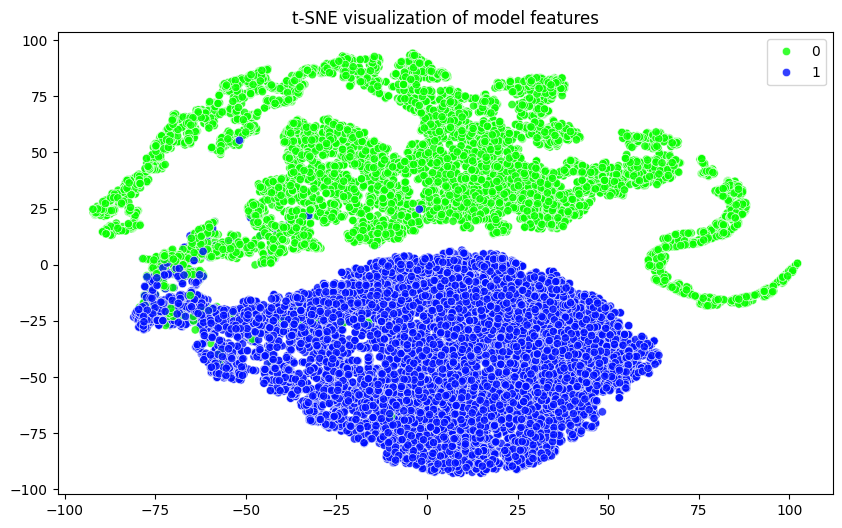

In [7]:
train_data_backdoor = BadEncoderBackdoor(numpy_file='../data/cifar10/train.npz', aug_transform=train_transform,clean_transform=test_transform_cifar10)
test_data_backdoor = BadEncoderBackdoor(numpy_file='../data/cifar10/test.npz', aug_transform=train_transform,clean_transform=test_transform_cifar10)

train_data_backdoor = DataLoader(train_data_backdoor, batch_size=1024, shuffle=True, num_workers=2)
test_data_bd_dl = DataLoader(test_data_backdoor, batch_size=1024, shuffle=True, num_workers=2)
train_and_test_model_tsne(model, train_data_backdoor, test_data_bd_dl)

100%|██████████| 72/72 [01:14<00:00,  1.04s/it]


Epoch 1/1, Train Loss: 12.0494


  4%|▍         | 1/26 [00:02<00:58,  2.36s/it]

torch.Size([2048, 2048])
torch.Size([2048, 2048])


 15%|█▌        | 4/26 [00:04<00:20,  1.07it/s]

torch.Size([2048, 2048])
torch.Size([2048, 2048])


 19%|█▉        | 5/26 [00:06<00:26,  1.27s/it]

torch.Size([2048, 2048])
torch.Size([2048, 2048])


 27%|██▋       | 7/26 [00:08<00:21,  1.15s/it]

torch.Size([2048, 2048])
torch.Size([2048, 2048])


 35%|███▍      | 9/26 [00:10<00:18,  1.09s/it]

torch.Size([2048, 2048])
torch.Size([2048, 2048])


 46%|████▌     | 12/26 [00:12<00:12,  1.15it/s]

torch.Size([2048, 2048])
torch.Size([2048, 2048])


 54%|█████▍    | 14/26 [00:14<00:10,  1.13it/s]

torch.Size([2048, 2048])
torch.Size([2048, 2048])


 58%|█████▊    | 15/26 [00:16<00:12,  1.16s/it]

torch.Size([2048, 2048])
torch.Size([2048, 2048])


 65%|██████▌   | 17/26 [00:18<00:10,  1.12s/it]

torch.Size([2048, 2048])
torch.Size([2048, 2048])


 73%|███████▎  | 19/26 [00:20<00:07,  1.09s/it]

torch.Size([2048, 2048])
torch.Size([2048, 2048])


 85%|████████▍ | 22/26 [00:23<00:03,  1.14it/s]

torch.Size([2048, 2048])
torch.Size([2048, 2048])


 88%|████████▊ | 23/26 [00:25<00:03,  1.10s/it]

torch.Size([2048, 2048])
torch.Size([2048, 2048])


 96%|█████████▌| 25/26 [00:27<00:01,  1.07s/it]

torch.Size([2048, 2048])


100%|██████████| 26/26 [00:27<00:00,  1.05s/it]

torch.Size([864, 2048])


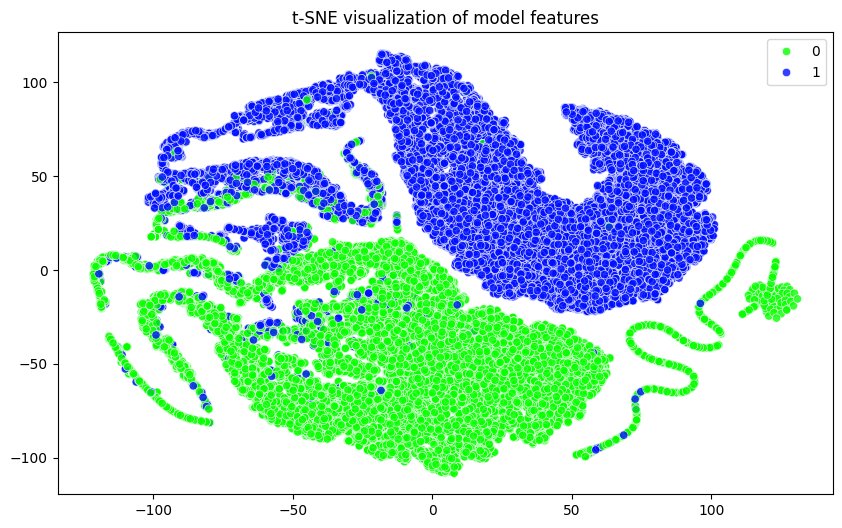

In [8]:
train_data_backdoor = BadEncoderBackdoor(numpy_file='../data/svhn/train.npz', aug_transform=train_transform,clean_transform=test_transform_cifar10)
test_data_backdoor = BadEncoderBackdoor(numpy_file='../data/svhn/test.npz', aug_transform=train_transform,clean_transform=test_transform_cifar10)

train_data_backdoor = DataLoader(train_data_backdoor, batch_size=1024, shuffle=True, num_workers=2)
test_data_bd_dl = DataLoader(test_data_backdoor, batch_size=1024, shuffle=True, num_workers=2)
train_and_test_model_tsne(model, train_data_backdoor, test_data_bd_dl)

100%|██████████| 2/2 [00:09<00:00,  4.56s/it]


Epoch 1/1, Train Loss: 12.3196


100%|██████████| 16/16 [00:08<00:00,  1.89it/s]


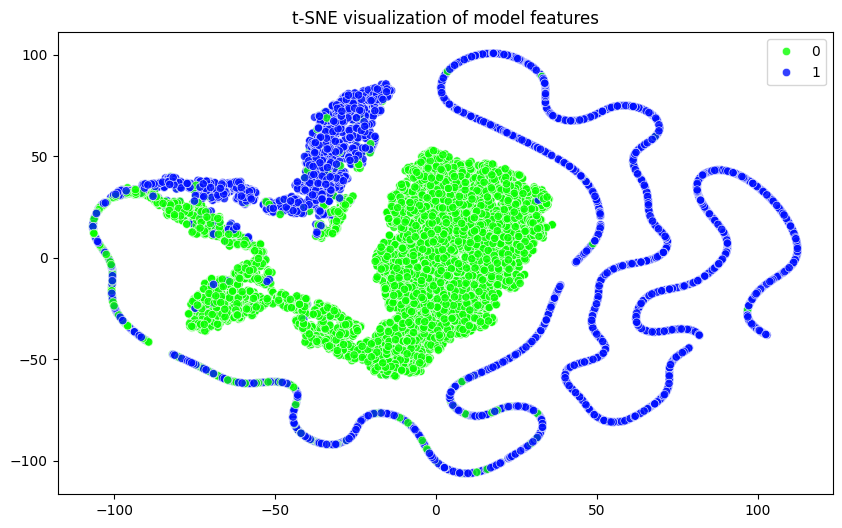

In [11]:
train_data_backdoor = BadEncoderBackdoor(numpy_file='../data/stl10/train.npz', aug_transform=train_transform,clean_transform=test_transform_cifar10)
test_data_backdoor = BadEncoderBackdoor(numpy_file='../data/stl10/test.npz', aug_transform=train_transform,clean_transform=test_transform_cifar10)

train_data_backdoor = DataLoader(train_data_backdoor, batch_size=4096, shuffle=True, num_workers=2)
test_data_bd_dl = DataLoader(test_data_backdoor, batch_size=4096, shuffle=True, num_workers=2)
test_data_bd_dl = DataLoader(test_data_backdoor, batch_size=512, shuffle=True, num_workers=2)
train_and_test_model_tsne(model, train_data_backdoor, test_data_bd_dl)

 20%|██        | 2/10 [00:09<00:31,  3.91s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcbe08c940>
Traceback (most recent call last):
  File "/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbcbe08c940>
Traceback (most recent call last):
  File "/home/hrzhang/anaconda3/envs/badencoder/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdo

Epoch 1/1, Train Loss: 12.3370


100%|██████████| 25/25 [00:12<00:00,  1.96it/s]


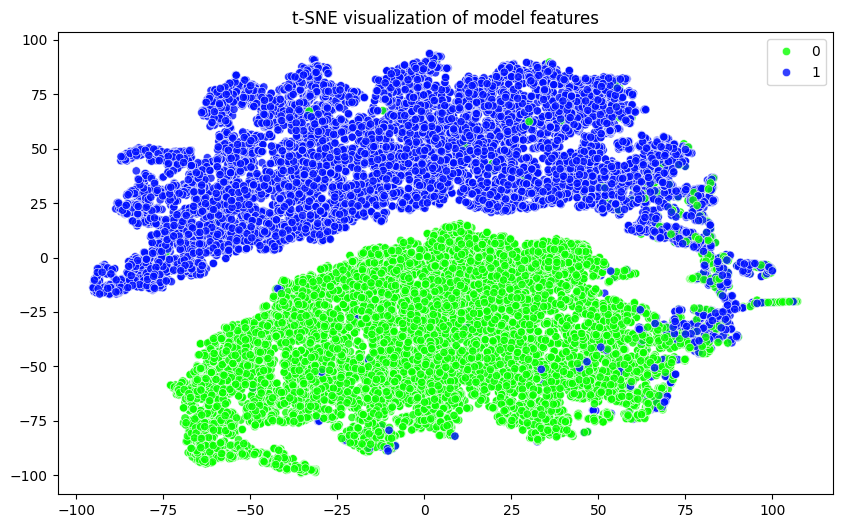

In [12]:
train_data_backdoor = BadEncoderBackdoor(numpy_file='../data/gtsrb/train.npz', aug_transform=train_transform,clean_transform=test_transform_cifar10)
test_data_backdoor = BadEncoderBackdoor(numpy_file='../data/gtsrb/test.npz', aug_transform=train_transform,clean_transform=test_transform_cifar10)

train_data_backdoor = DataLoader(train_data_backdoor, batch_size=4096, shuffle=True, num_workers=2)
test_data_bd_dl = DataLoader(test_data_backdoor, batch_size=4096, shuffle=True, num_workers=2)
test_data_bd_dl = DataLoader(test_data_backdoor, batch_size=512, shuffle=True, num_workers=2)
train_and_test_model_tsne(model, train_data_backdoor, test_data_bd_dl)

In [5]:
train_data_backdoor = BadEncoderBackdoor(numpy_file='../data/cifar10/train.npz', aug_transform=train_transform,clean_transform=test_transform_cifar10)
test_data_backdoor = BadEncoderBackdoor(numpy_file='../data/cifar10/test.npz', aug_transform=train_transform,clean_transform=test_transform_cifar10)

train_data_backdoor = DataLoader(train_data_backdoor, batch_size=4096, shuffle=True, num_workers=2)
test_data_bd_dl = DataLoader(test_data_backdoor, batch_size=4096, shuffle=True, num_workers=2)
train_and_test_model_with_epochs(model, train_data_backdoor, test_data_bd_dl)

100%|██████████| 13/13 [00:53<00:00,  4.08s/it]


Epoch 1/30, Train Loss: 0.5244


100%|██████████| 13/13 [00:52<00:00,  4.03s/it]


Epoch 2/30, Train Loss: 0.0389


100%|██████████| 13/13 [00:52<00:00,  4.03s/it]


Epoch 3/30, Train Loss: 0.0271


100%|██████████| 13/13 [00:52<00:00,  4.05s/it]


Epoch 4/30, Train Loss: 0.0186


100%|██████████| 13/13 [00:52<00:00,  4.03s/it]


Epoch 5/30, Train Loss: 0.0139


100%|██████████| 13/13 [00:52<00:00,  4.05s/it]


Epoch 6/30, Train Loss: 0.0121


100%|██████████| 13/13 [00:51<00:00,  3.98s/it]


Epoch 7/30, Train Loss: 0.0112


100%|██████████| 13/13 [00:53<00:00,  4.08s/it]


Epoch 8/30, Train Loss: 0.0107


100%|██████████| 13/13 [00:52<00:00,  4.01s/it]


Epoch 9/30, Train Loss: 0.0083


100%|██████████| 13/13 [00:52<00:00,  4.05s/it]


Epoch 10/30, Train Loss: 0.0091


100%|██████████| 13/13 [00:53<00:00,  4.09s/it]


Epoch 11/30, Train Loss: 0.0082


100%|██████████| 13/13 [00:52<00:00,  4.04s/it]


Epoch 12/30, Train Loss: 0.0060


100%|██████████| 13/13 [00:52<00:00,  4.04s/it]


Epoch 13/30, Train Loss: 0.0069


100%|██████████| 13/13 [00:52<00:00,  4.04s/it]


Epoch 14/30, Train Loss: 0.0061


100%|██████████| 13/13 [00:52<00:00,  4.05s/it]


Epoch 15/30, Train Loss: 0.0063


100%|██████████| 13/13 [00:52<00:00,  4.04s/it]


Epoch 16/30, Train Loss: 0.0057


100%|██████████| 13/13 [00:52<00:00,  4.07s/it]


Epoch 17/30, Train Loss: 0.0059


100%|██████████| 13/13 [00:52<00:00,  4.03s/it]


Epoch 18/30, Train Loss: 0.0048


100%|██████████| 13/13 [00:52<00:00,  4.03s/it]


Epoch 19/30, Train Loss: 0.0055


100%|██████████| 13/13 [00:52<00:00,  4.02s/it]


Epoch 20/30, Train Loss: 0.0046


100%|██████████| 13/13 [00:52<00:00,  4.05s/it]


Epoch 21/30, Train Loss: 0.0041


100%|██████████| 13/13 [00:51<00:00,  4.00s/it]


Epoch 22/30, Train Loss: 0.0037


100%|██████████| 13/13 [00:53<00:00,  4.11s/it]


Epoch 23/30, Train Loss: 0.0046


100%|██████████| 13/13 [00:53<00:00,  4.09s/it]


Epoch 24/30, Train Loss: 0.0055


100%|██████████| 13/13 [00:52<00:00,  4.05s/it]


Epoch 25/30, Train Loss: 0.0053


100%|██████████| 13/13 [00:52<00:00,  4.01s/it]


Epoch 26/30, Train Loss: 0.0054


100%|██████████| 13/13 [00:52<00:00,  4.03s/it]


Epoch 27/30, Train Loss: 0.0056


100%|██████████| 13/13 [00:52<00:00,  4.03s/it]


Epoch 28/30, Train Loss: 0.0036


100%|██████████| 13/13 [00:49<00:00,  3.83s/it]


Epoch 29/30, Train Loss: 0.0037


100%|██████████| 13/13 [00:48<00:00,  3.74s/it]


Epoch 30/30, Train Loss: 0.0039


100%|██████████| 3/3 [00:12<00:00,  4.10s/it]

Accuracy: 99.70%, F1 Score: 0.9971, AUROC: 1.0000


In [1]:
train_data_backdoor = BadEncoderBackdoor(numpy_file='../data/stl10/train.npz', aug_transform=train_transform,clean_transform=test_transform_cifar10)
test_data_backdoor = BadEncoderBackdoor(numpy_file='../data/stl10/test.npz', aug_transform=train_transform,clean_transform=test_transform_cifar10)

train_data_backdoor = DataLoader(train_data_backdoor, batch_size=4096, shuffle=True, num_workers=2)
test_data_bd_dl = DataLoader(test_data_backdoor, batch_size=4096, shuffle=True, num_workers=2)
test_data_bd_dl = DataLoader(test_data_backdoor, batch_size=512, shuffle=True, num_workers=2)
train_and_test_model_with_epochs(model, train_data_backdoor, test_data_bd_dl)

NameError: name 'BadEncoderBackdoor' is not defined

In [3]:
train_data_backdoor = BadEncoderBackdoor(numpy_file='../data/svhn/train.npz', aug_transform=train_transform,clean_transform=test_transform_cifar10)
test_data_backdoor = BadEncoderBackdoor(numpy_file='../data/svhn/test.npz', aug_transform=train_transform,clean_transform=test_transform_cifar10)

train_data_backdoor = DataLoader(train_data_backdoor, batch_size=4096, shuffle=True, num_workers=2)
test_data_bd_dl = DataLoader(test_data_backdoor, batch_size=4096, shuffle=True, num_workers=2)
train_and_test_model_with_epochs(model, train_data_backdoor, test_data_bd_dl)

100%|██████████| 18/18 [01:07<00:00,  3.74s/it]


Epoch 1/30, Train Loss: 0.2594


  0%|          | 0/18 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
train_data_backdoor = BadEncoderBackdoor(numpy_file='../data/gtsrb/train.npz', aug_transform=train_transform,clean_transform=test_transform_cifar10)
test_data_backdoor = BadEncoderBackdoor(numpy_file='../data/gtsrb/test.npz', aug_transform=train_transform,clean_transform=test_transform_cifar10)

train_data_backdoor = DataLoader(train_data_backdoor, batch_size=4096, shuffle=True, num_workers=2)
test_data_bd_dl = DataLoader(test_data_backdoor, batch_size=4096, shuffle=True, num_workers=2)
train_and_test_model_with_epochs(model, train_data_backdoor, test_data_bd_dl)

100%|██████████| 4/4 [00:17<00:00,  4.34s/it]

准确率: 96.52%, F1得分: 0.9651, AUROC: 0.9946
